# Twitter Sentiment Analysis Project

## Part I - Tweets collection
## Part II - Sentiment Analysis

In [1]:
# python standard library
import os

In [2]:
# library to communicate with the Twitter API
import tweepy

In [3]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
import nltk.collocations as nc
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

C:\Users\RodneyWeakly\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
# add additional stop words to the basic English list and save as a set
en_stopwords = set(stopwords.words('english')+ ['RT', 'crash', 'accident', 'rt'])
nlp = spacy.load('en_core_web_sm')

### Accessing Environment Variables

In [5]:
# Note: Twitter account access keys are saved as environment variables

# accessing environment variable in the code
consumer_key = os.environ.get('TWITTER_CONSUMER_KEY')
consumer_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
access_token_key = os.environ.get('TWITTER_ACCESS_TOKEN_KEY')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

In [6]:
# test if the keys are in the runtime enviroment
print('Found consumer_key:', bool(consumer_key))
print('Found consumer_secret:', bool(consumer_secret))
print('Found access_token_key:', bool(access_token_key))
print('Found access_token_secret:', bool(access_token_secret))

Found consumer_key: True
Found consumer_secret: True
Found access_token_key: True
Found access_token_secret: True


In [7]:
# get Twitter authorization
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)

api = tweepy.API(auth)

In [8]:
# load tweets from my home timeline
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

RT @ColoradoEagles: EAGLES WIN!

And Martin gets his first win and first shutout as an Eagle!

#EaglesCountry https://t.co/3HUZhQZqHp
RT @HC_WJC: GAME OVER! @shanebowers15 scores the shootout winner, and 🇨🇦 tops @USPORTSca 3-2. Game stats: https://t.co/1x7rWZeKrk #WorldJun…
12.12.18

#GoAvsGo https://t.co/u7dUuoOjWE
RT @NWSBoulder: Strong wind gusts will continue tonight as winds have already reached 52 mph at Limon. Tomorrow, the system will depart wit…
#Contact7: Christmas comes early for domestic violence victim and her family: https://t.co/6AYU5BfLVj via @TomMustin https://t.co/8lVxUVV5Go
RT @lvs2rdhrses: Well I did it again. I elfed T-Beauts, Colesy, and the Favs 😂 Enjoy! 

I hope you all have a wonderful holiday!! #LoveMyTe…
"@skignome: Colorado Love right there! @Colorado" https://t.co/VrxWsfekfR
RT @Broncos: He hosts fundraisers.
He donates money.
He helps give thousands of kids the gift of sight.

But it's these small interactions…
AJ Greer was on a four-game point streak befo

### Using tweepy to search for tweets in a particular area

In [9]:
#Search for tweets about car accidents within 10 miles of Central Park and MLK in Denver 
results = api.search('accident OR crash OR collision', geocode='39.7602773,-104.8904864,10mi')

In [10]:
# How many tweets found?
len(results)

15

In [11]:
# Display text from the last tweet to check content
results[14]._json['text']

'RT @T_Wes44: 5 years ago I was involved in a roll over car accident that left me paralyzed from the shoulders down. This is my progress tod…'

In [12]:
### Extracting the tweets

In [13]:
def extract_text(tweets):
    """Returns a list of strings holding the text of the tweets"""
    return [tweet._json['text'] for tweet in tweets]

In [14]:
text_results = extract_text(results)
text_results[:3]

['RT @CBSDenver: Millennials lacking life skills - like cooking, budgeting, or time management - are now signing up for classes designed to t…',
 'RT @cnalive: “I personally attributed that to the intercession of Our Lady, and so did the other passengers, I think most of us...saw it as…',
 'RT @cnalive: “I personally attributed that to the intercession of Our Lady, and so did the other passengers, I think most of us...saw it as…']

### Gathering the max number of tweets on the topic

In [15]:
from tweepy import Cursor

In [16]:
# searching for tweets and saving text only
tweets = [tweet._json['text'] for tweet in Cursor(api.search,'accident OR crash OR collision', geocode='39.7602773,-104.8904864,10mi').items()]

In [17]:
# How many tweets found?
len(tweets)

1850

In [18]:
# look at the first 3 tweets
tweets[:3]

['RT @CBSDenver: Millennials lacking life skills - like cooking, budgeting, or time management - are now signing up for classes designed to t…',
 'RT @cnalive: “I personally attributed that to the intercession of Our Lady, and so did the other passengers, I think most of us...saw it as…',
 'RT @cnalive: “I personally attributed that to the intercession of Our Lady, and so did the other passengers, I think most of us...saw it as…']

### Clean the tweets

In [19]:
def preprocess_text(text_docs):
    """
    text preprocessing using spacy:
    lowercase, tokenize, remove whitespaces, remove stopwords, lemmatize;
    returns list of cleaned, preprocessed strings
    """
    # remove punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    docs = [d.translate(table) for d in text_docs]
    # replace new lines with spaces
    docs = [re.sub('[\r\n]+', ' ', d) for d in docs]
    # replace URLs with spaces
    docs = [re.sub('https[\w]*', ' ', d) for d in docs]
    # replace digits with space
    docs = [re.sub('\d', ' ', d) for d in docs]
    # replace multiple spaces with one space
    docs = [re.sub('\s\s+', ' ', d) for d in docs]
    # use spacy for lemmatization
    spacy_docs = [nlp(d) for d in docs]
    docs=[]
    for d in spacy_docs: #for each document
        temp_doc=[]
        for w in d: #for each word in a document
            #remove stopwords, pronouns, numbers and "wods" that are shorter than 2 and longer than 20 letters
            if w.lemma_ in en_stopwords or w.lemma_.isdigit() or len(w.lemma_) > 20 or len(w.lemma_) < 2:
                continue #skip the word and go back to the beginning of the loop
            elif w.lemma_ != '-PRON-':
                temp_doc.append(w.lower_) #append the lower case word
                
        docs.append(' '.join(temp_doc))

    return docs
       
    

In [20]:
cleaned_tweets = preprocess_text(tweets) #call preprocess_text function to clean up the tweets
cleaned_tweets[:3] #display first three tweets after clean-up

['cbsdenver millennials lacking life skills like cooking budgeting time management signing classes designed',
 'cnalive personally attributed intercession lady passengers think ussaw',
 'cnalive personally attributed intercession lady passengers think ussaw']

### Write tweets to file

In [21]:
# specify file name
filename = 'tweets_denver_carcrashes_week8_2.txt'

In [22]:
def write_out_tweets(filename, lines):
    """Writes tweets to a text file"""
    with open(filename, 'w', encoding='utf-8') as out_file: #encoding='utf-8' - keep only regular text characters
        for line in lines:
            out_file.write(line + os.linesep)

In [23]:
# call write_out_tweets function to save cleaned results to the file
write_out_tweets(filename, cleaned_tweets)

In [24]:
#wrtie unprocessed tweets to a file
write_out_tweets("text_only_week8_2.txt", text_results)

In [25]:
#Does the file exist?
#using os library since running on Windows 10
os.path.isfile(filename)

True

In [26]:
#Check file size (to make sure it is not empty)
os.stat(filename).st_size

137921

### Reading tweets using pandas

In [27]:
def read_in_tweets(filename):
    """reads tweets from a file into a data frame"""
    return pd.read_csv(filename, index_col=False, header=None, names=['tweet'])

In [28]:
cleaned_tweets_restored = read_in_tweets(filename) #call read_in_tweets function to read tweets into a df
cleaned_tweets_restored.head() #display the first few tweets

,tweet
0,cbsdenver millennials lacking life skills like...
1,cnalive personally attributed intercession lad...
2,cnalive personally attributed intercession lad...
3,cnalive personally attributed intercession lad...
4,trump panicking stocks job report disaster


In [29]:
type(cleaned_tweets_restored), cleaned_tweets_restored.shape #check the data type and its size 

(pandas.core.frame.DataFrame, (1849, 1))

## Sentiment Analysis

In [30]:
# create the sentiment analysis object
sia = SIA()

In [31]:
# apply polarity_scores function to the tweets and save results in a new column
cleaned_tweets_restored['polarity'] = cleaned_tweets_restored['tweet'].apply(sia.polarity_scores)

In [32]:
cleaned_tweets_restored.head() #check results

,tweet,polarity
0,cbsdenver millennials lacking life skills like...,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
1,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,trump panicking stocks job report disaster,"{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'comp..."


In [33]:
# create 4 new columns using keys as column names
#apply Series constructor to the 'polarity' columns to split values in the dictionary into separate columns
polarity_df = cleaned_tweets_restored['polarity'].apply(pd.Series)
polarity_df.head() #check results

,neg,neu,pos,compound
0,0.000,0.828,0.172,0.3612
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.636,0.364,0.000,-0.7906


In [34]:
#join the data frames into one
cleaned_tweets_restored = cleaned_tweets_restored.join([polarity_df])
cleaned_tweets_restored.head() #check results

,tweet,polarity,neg,neu,pos,compound
0,cbsdenver millennials lacking life skills like...,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",0.000,0.828,0.172,0.3612
1,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
2,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
3,cnalive personally attributed intercession lad...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,trump panicking stocks job report disaster,"{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'comp...",0.636,0.364,0.000,-0.7906


In [35]:
# drop the original 'polarity' column
cleaned_tweets_restored = cleaned_tweets_restored.drop(['polarity'], axis = 1)

In [36]:
cleaned_tweets_restored.head() #check results

,tweet,neg,neu,pos,compound
0,cbsdenver millennials lacking life skills like...,0.000,0.828,0.172,0.3612
1,cnalive personally attributed intercession lad...,0.000,1.000,0.000,0.0000
2,cnalive personally attributed intercession lad...,0.000,1.000,0.000,0.0000
3,cnalive personally attributed intercession lad...,0.000,1.000,0.000,0.0000
4,trump panicking stocks job report disaster,0.636,0.364,0.000,-0.7906


In [37]:
#create a plot
import matplotlib.pyplot as plt

Text(0,0.5,'Count')

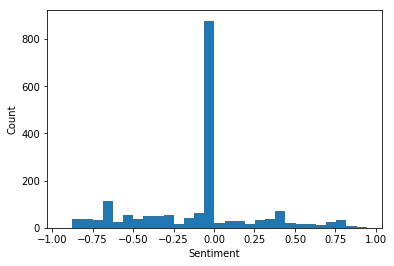

In [38]:
# hisogram: number of tweets for each sentiment value
plt.hist(cleaned_tweets_restored['compound'], bins = 30)
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [39]:
# remove all neutral tweets using a mask
not_neutral = cleaned_tweets_restored[cleaned_tweets_restored['neu'] != 1.0]
not_neutral.shape

(985, 5)

Text(0,0.5,'Count')

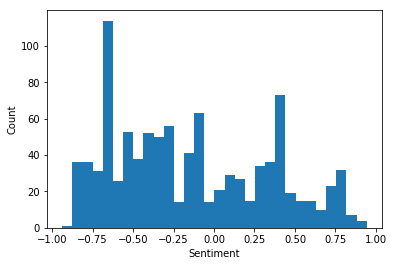

In [40]:
#create histogram without neutral sentiment
plt.hist(not_neutral['compound'], bins = 30)
plt.xlabel('Sentiment')
plt.ylabel('Count')

In [41]:
from nltk import FreqDist, word_tokenize
from itertools import chain

In [42]:
def flatten_word_list(series):
    """returns a list of words"""
    return list(chain.from_iterable([word_tokenize(line) for line in series]))

In [43]:
#tweets with positive sentiment
positive = cleaned_tweets_restored[cleaned_tweets_restored['pos'] > 0.35]

In [44]:
#How many positive tweets found?
len(positive)

121

In [45]:
#Look at the first 20 positive twets
positive[:20]

,tweet,neg,neu,pos,compound
47,stevezaragoza may ready going watch like car s...,0.000,0.583,0.417,0.6124
50,jeffcosheriffco clear creek canyon,0.000,0.536,0.464,0.3818
51,gustavqq unable let players reenter competitiv...,0.000,0.538,0.462,0.5106
52,coloradodot clear creek canyon,0.000,0.536,0.464,0.3818
79,drsearswellness crashdiets tempting due promis...,0.000,0.629,0.371,0.7579
83,crashdiets tempting due promise fast results r...,0.000,0.581,0.419,0.7579
129,invresdynamics roflmao daveramsey dave see las...,0.000,0.632,0.368,0.7506
175,sedrickavenue dropped phone lol tragic part 🏻‍...,0.167,0.444,0.389,0.6124
176,bigjbeats good,0.000,0.256,0.744,0.4404
204,invresdynamics roflmao daveramsey dave see las...,0.000,0.632,0.368,0.7506


In [46]:
#list of positive words
positive_words = flatten_word_list(positive['tweet'])
len(positive_words), positive_words[:5] #How many total positive words? Print first five as an example

(1013, ['stevezaragoza', 'may', 'ready', 'going', 'watch'])

In [47]:
#create frequency distribution of positive words
pos_fd = FreqDist(positive_words)

In [48]:
# ten most common words in positive tweets
pos_fd.most_common(10)

[('good', 32),
 ('last', 17),
 ('hope', 17),
 ('like', 13),
 ('clear', 12),
 ('please', 12),
 ('help', 12),
 ('family', 12),
 ('everyone', 11),
 ('weekend', 11)]

In [49]:
#tweets with negative sentiment
negative = cleaned_tweets_restored[cleaned_tweets_restored['neg'] > 0.35]

In [50]:
#How many negative tweets found?
len(negative)

263

In [51]:
#Look at the first 20 negative twets
negative[:20]

,tweet,neg,neu,pos,compound
4,trump panicking stocks job report disaster,0.636,0.364,0.000,-0.7906
5,even better scene kyle says fucking hates ugh ...,0.388,0.433,0.179,-0.5222
73,jkhansenaz homicide suicide staged crime scene...,0.471,0.529,0.000,-0.8402
76,jkhansenaz homicide suicide staged crime scene...,0.471,0.529,0.000,-0.8402
80,goal chaos disruption seems short sighted glob...,0.356,0.460,0.184,-0.4588
89,seanhannity insanity cherry picked thisthats s...,0.481,0.519,0.000,-0.7579
96,jkhansenaz homicide suicide staged crime scene...,0.471,0.529,0.000,-0.8402
99,jkhansenaz homicide suicide happened janycehan...,0.360,0.640,0.000,-0.6705
100,homicide suicide staged crime scene happened j...,0.533,0.467,0.000,-0.8402
114,kycutter jimjordan saracarterdc trump cult wei...,0.624,0.376,0.000,-0.8074


In [52]:
#list of negative words
negative_words = flatten_word_list(negative['tweet'])
len(negative_words), negative_words[:5] #How many total positive words? Print first five as an example

(2297, ['trump', 'panicking', 'stocks', 'job', 'report'])

In [53]:
#create frequency distribution of negative words
neg_fd = FreqDist(negative_words)

In [54]:
# ten most common words in negative tweets
neg_fd.most_common(10)

[('homicide', 47),
 ('suicide', 47),
 ('janycehansen', 47),
 ('happened', 43),
 ('jkhansenaz', 42),
 ('night', 42),
 ('sept', 42),
 ('hekilledourjanny', 38),
 ('familys', 36),
 ('dead', 30)]

Conclusions:
1. Tweets collected using "crash OR  accident OR collision" keywords varied depending on time of collection. During day time (output file tweets_denver_carcrashes_week8.txt) they mostly contained posts about traffic accidents within the defined area. In the evening (after evening rush hour, see output file tweets_denver_carcrashes_week8_2.txt), the tweets mostly contained the word "crash" but in relation to the market crash and political discussions. So, there is a need to better define search criteria.
2. Due to the topic, the majority of the tweets had more pronounced negative sentiment.
3. I excluded the words "crash" and "accident" from the cleaned texts, but it did not really have influence on extracting other meaninful words.